In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_matches = pd.read_csv('../../data/preprocessed/preprocessed_1.csv')
df_matches.sort_values(by=["season", "stage", "date"], inplace=True)

season_dummies = pd.get_dummies(df_matches['season'], prefix='season', drop_first=True)
df_matches = df_matches.join(season_dummies)

In [3]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score


def train_and_evaluate(train_df, val_df, test_df):
    feature_cols = [col for col in train_df.columns if col not in
                    ["match_api_id", "result_match", "season", "stage", "date", "home_team", "away_team"]]

    X_train = train_df[feature_cols]
    y_train = train_df["result_match"]

    X_val = val_df[feature_cols]
    y_val = val_df["result_match"]

    X_test = test_df[feature_cols]
    y_test = test_df["result_match"]

    params = {'colsample_bytree': 0.7829898393185475,
              'gamma': 0.9781297636451665,
              'learning_rate': 0.2115010625918003,
              'max_depth': 35,
              'n_estimators': 900,
              'reg_alpha': 0.0011999980355188625,
              'reg_lambda': 0.02970755465742397,
              'subsample': 0.8031599422338628}

    model = XGBClassifier(
        **params,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss",

    )

    # Fit on training and validate on validation set
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average="binary")

In [4]:
# ---------------------
# Backtesting over multiple seasons
# ---------------------

seasons = sorted(df_matches["season"].unique(), reverse=True)
backtest_results = []

for i in range(1, len(seasons)):
    target_season = seasons[0]
    previous_seasons = seasons[1:1 + i]

    target_season_df = df_matches[df_matches["season"] == target_season]

    target_stages = sorted(target_season_df["stage"].unique())

    for stage in target_stages:
        if stage <= min(target_stages) + 1:
            continue

        train_df_prev = df_matches[df_matches["season"].isin(previous_seasons)]
        train_df_target = target_season_df[target_season_df["stage"] < (stage - 1)]
        train_df = pd.concat([train_df_prev, train_df_target], ignore_index=True)

        val_df = target_season_df[target_season_df["stage"] == (stage - 1)]
        test_df = target_season_df[target_season_df["stage"] == stage]

        if train_df.empty or val_df.empty or test_df.empty:
            continue

        f1 = train_and_evaluate(train_df, val_df, test_df)
        backtest_results.append({
            "season": f"{target_season} - {len(previous_seasons)}",
            "stage": stage,
            "train_size": len(train_df),
            "f1_score": f1
        })

results_df = pd.DataFrame(backtest_results)
print("Backtesting results for each season and stage:")
results_df

Backtesting results for each season and stage:


,season,stage,train_size,f1_score
0,2015/2016 - 1,3,379,0.000000
1,2015/2016 - 1,4,387,0.571429
2,2015/2016 - 1,5,396,0.400000
3,2015/2016 - 1,6,406,0.285714
4,2015/2016 - 1,7,416,0.750000
...,...,...,...,...
247,2015/2016 - 7,34,2915,0.333333
248,2015/2016 - 7,35,2925,0.800000
249,2015/2016 - 7,36,2935,0.800000
250,2015/2016 - 7,37,2945,0.545455


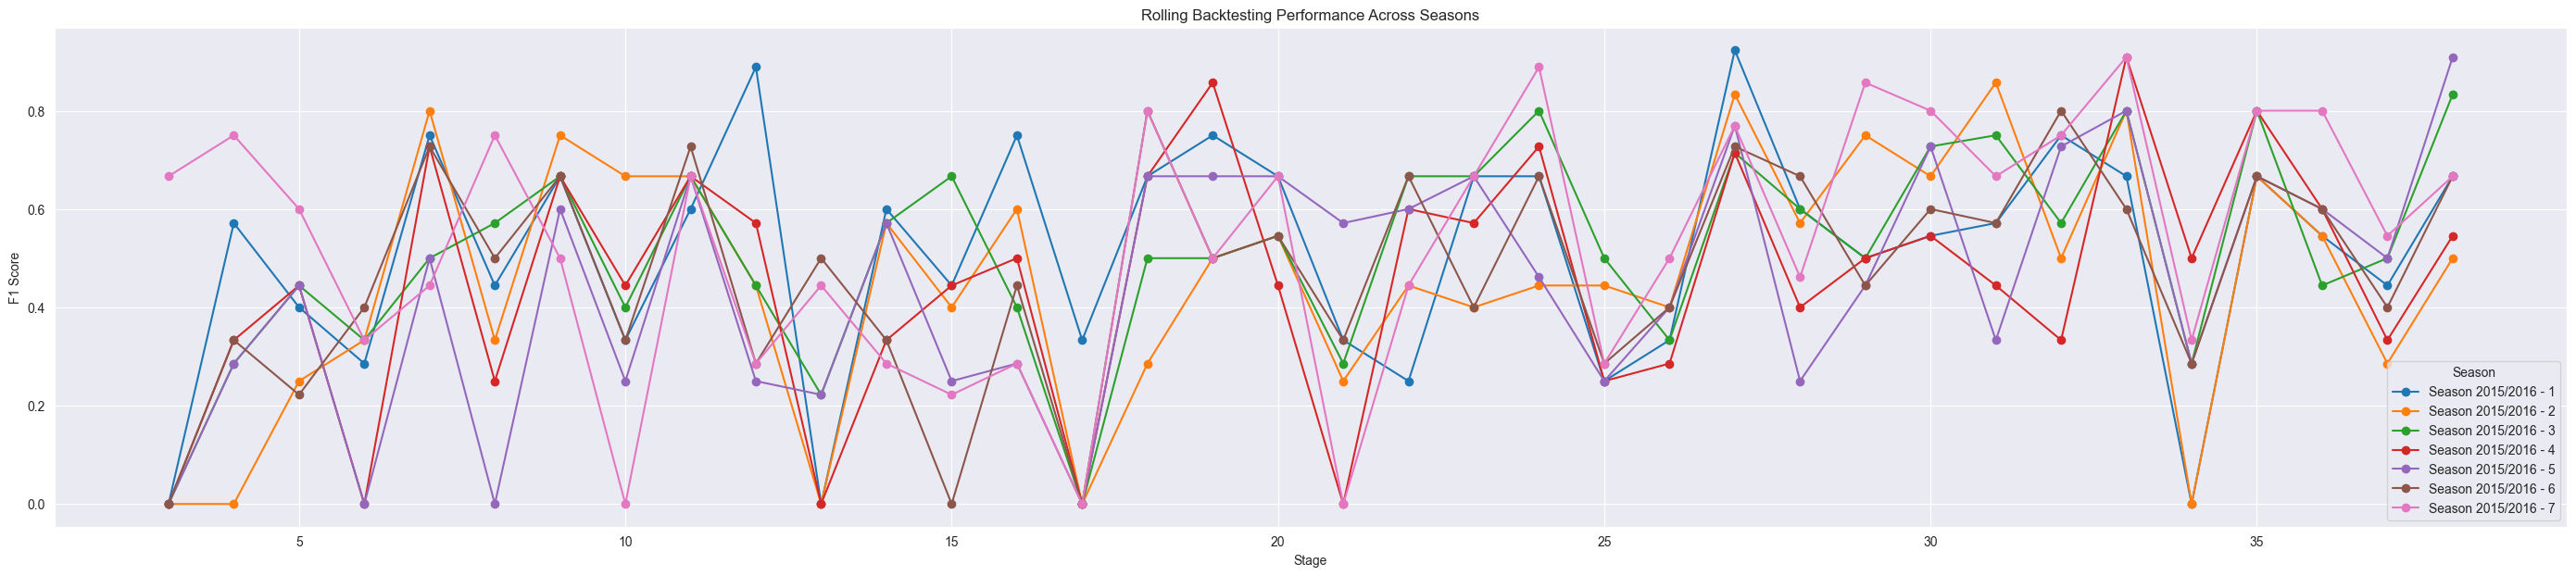

In [5]:
plt.figure(figsize=(35, 7))
for season in results_df["season"].unique():
    season_results = results_df[results_df["season"] == season]
    plt.plot(season_results["stage"], season_results["f1_score"], marker="o", label=f"Season {season}")

plt.xlabel("Stage")
plt.ylabel("F1 Score")
plt.title("Rolling Backtesting Performance Across Seasons")
plt.legend(title="Season")
plt.grid(True)
plt.show()


Average F1 Score for each season:
          season  avg_f1_score
0  2015/2016 - 1      0.514762
1  2015/2016 - 2      0.458522
2  2015/2016 - 3      0.513815
3  2015/2016 - 4      0.455836
4  2015/2016 - 5      0.452468
5  2015/2016 - 6      0.475008
6  2015/2016 - 7      0.537401


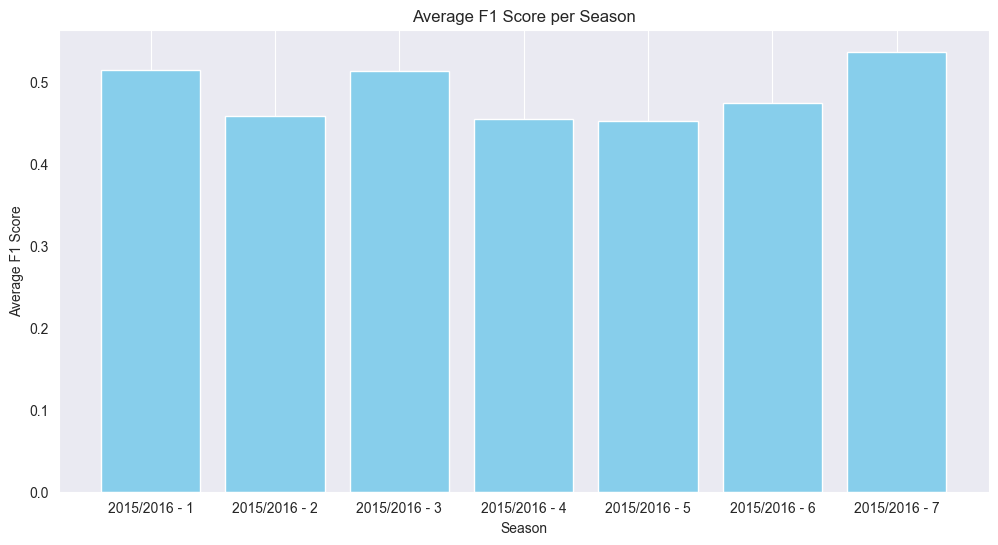

In [6]:
avg_results = results_df.groupby("season")["f1_score"].mean().reset_index()
avg_results.rename(columns={"f1_score": "avg_f1_score"}, inplace=True)
print("\nAverage F1 Score for each season:")
print(avg_results)

plt.figure(figsize=(12, 6))
plt.bar(avg_results["season"].astype(str), avg_results["avg_f1_score"], color='skyblue')
plt.xlabel("Season")
plt.ylabel("Average F1 Score")
plt.title("Average F1 Score per Season")
plt.grid(axis='y')
plt.show()